(-0.2, 1.268536259208993)

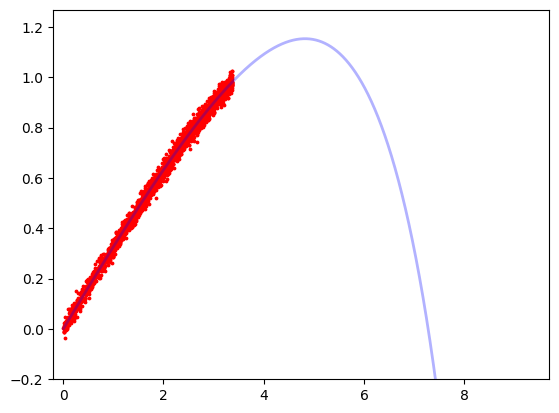

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.ion()

from torch.autograd import Variable

import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
from torch.func import functional_call, grad, vmap, jacrev, jacfwd, hessian
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, LBFGS
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
plt.ion()
import tqdm
from tkinter.filedialog import asksaveasfilename

g = 9.8
mu = 0.3

def fun(t, V):
    vx, vy = V
    drag = mu*np.sqrt(vx**2+vy**2)
    return [-drag*vx, -drag*vy-g]

V_0 = [30, 10]
ts = np.linspace(0, 2, 10000)
dt = ts[1]-ts[0]

result = solve_ivp(fun, (0, 100), V_0, t_eval=ts)
sx = np.cumsum(result.y[0])*dt
sy = np.cumsum(result.y[1])*dt

ts_train = np.linspace(0, 0.2, 2000)
dt_train = ts_train[1]-ts_train[0]
result_train = solve_ivp(fun, (0, 100), V_0, t_eval=ts_train)
t_train = result_train.t
sx_train = np.cumsum(result_train.y[0])*dt_train
sy_train = np.cumsum(result_train.y[1])*dt_train

noise_x = np.random.normal(0, 0.03, len(t_train))
noise_y = np.random.normal(0, 0.02, len(t_train))

#sx_train = [x+n for x, n in zip(sx_train, noise_x)]
sy_train = [y+n for y, n in zip(sy_train, noise_y)]

plt.plot(sx, sy, c='b', alpha=0.3, linewidth=2)
plt.scatter(sx_train, sy_train, c='r', s=3)
plt.xlim(-0.2, np.max(sx)*1.1)
plt.ylim(-0.2, np.max(sy)*1.1)



In [10]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.relu = torch.tanh
        self.lin_1 = nn.Linear(1, 60)
        self.lin_2 = nn.Linear(60, 2)

    def forward(self, x):
        x = self.lin_1(x)
        x = self.lin_2(self.relu(x))
        return x.squeeze()

""" Define dataset.  self.p instance is to specify IVs and BCs """
class MyDataset(Dataset):

    def __init__(self, time_tensor, pos_tensor):
        self.t = time_tensor
        self.s = pos_tensor

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.s[idx]
    


In [8]:
loss_basic_fcn = torch.nn.MSELoss()

t_train_tensor = torch.tensor(t_train, dtype=torch.float32)
t_train_tensor = t_train_tensor.reshape(len(t_train), -1)
s_train_tensor = torch.tensor([[sx, sy] for sx, sy in zip(sx_train, sy_train)], dtype=torch.float32)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

phys_contrib = 1

model = Net().to(DEVICE)

train_dataset = MyDataset(t_train_tensor, s_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

loss_best = 1000

def phys_loss(inp, out):
    out_x = out[:, 0]
    out_y = out[:, 1]
    grad_outputs = torch.ones_like(out_x)
    vx = torch.autograd.grad(out_x, [inp], grad_outputs=grad_outputs, create_graph=True)[0]
    vy = torch.autograd.grad(out_y, [inp], grad_outputs=grad_outputs, create_graph=True)[0]
    vnorm = torch.sqrt(vx**2+vy**2)
    grad_outputs = torch.ones_like(vx)
    ax = torch.autograd.grad(vx, [inp], grad_outputs=grad_outputs, create_graph=True)[0]
    ay = torch.autograd.grad(vy, [inp], grad_outputs=grad_outputs, create_graph=True)[0]
    tmp_loss_vx = -mu*vnorm*vx-ax
    tmp_loss_vy = -mu*vnorm*vy-g-ay

    return torch.square(tmp_loss_vx) + torch.square(tmp_loss_vy)

adam_epochs = 300
lbfgs_epochs = 200

optimizer_adam = Adam(model.parameters(), lr=0.001)
scheduler_adam = LambdaLR(optimizer=optimizer_adam,
                          lr_lambda=lambda epoch: 0.99 ** epoch,
                          last_epoch=-1)

for epoch in range(0, adam_epochs):
    for batch_t, batch_s in train_dataloader:
        batch_size = batch_t.shape[0]
        batch_t.to(DEVICE)
        batch_s.to(DEVICE)
        model.train()
        batch_t = Variable(batch_t, requires_grad=True)
        def closure_adam():
            optimizer_adam.zero_grad()
            loss = loss_basic_fcn(model(batch_t), batch_s) + phys_contrib*torch.sum(phys_loss(batch_t, model(batch_t)))/batch_size
            loss.backward()
            return loss
        optimizer_adam.step(closure_adam)
    #scheduler_adam.step()

    model.eval()
    train_prediction = model(t_train_tensor)
    train_loss = loss_basic_fcn(train_prediction, s_train_tensor) + phys_contrib*torch.sum(phys_loss(batch_t, model(batch_t)))/batch_size

    print(f"Epoch: {epoch+1} | Train Loss: {round(float(train_loss), 5)}")

optimizer_lbfgs = LBFGS(model.parameters(), lr=0.002)
scheduler_lbfgs = LambdaLR(optimizer=optimizer_lbfgs,
                           lr_lambda=lambda epoch: 0.99 ** epoch,
                           last_epoch=-1)

for epoch in range(0, lbfgs_epochs):
    for batch_t, batch_s in train_dataloader:
        batch_size = batch_t.shape[0]
        batch_t.to(DEVICE)
        batch_s.to(DEVICE)
        model.train()
        batch_t = Variable(batch_t, requires_grad=True)
        def closure_lfbgs():
            optimizer_lbfgs.zero_grad()
            loss = loss_basic_fcn(model(batch_t), batch_s) + phys_contrib*torch.sum(phys_loss(batch_t, model(batch_t)))/batch_size
            loss.backward()
            return loss
        optimizer_lbfgs.step(closure_adam)
    #scheduler_lbfgs.step()

    model.eval()
    train_prediction = model(t_train_tensor)
    train_loss = loss_basic_fcn(train_prediction, s_train_tensor) + phys_contrib*torch.sum(phys_loss(batch_t, model(batch_t)))/batch_size

    print(f"Epoch: {epoch+1} | Train Loss: {round(float(train_loss), 5)}")

t_test_tensor = torch.tensor(np.linspace(0, 10, 10000), dtype=torch.float32).reshape(10000, -1)

pred_s = model(t_test_tensor).detach().numpy()

fig, axs = plt.subplots(3, 1, figsize=(6,10))

axs[0].plot(sx, sy, c='b', alpha=0.3, linewidth=4)
axs[0].plot(pred_s[:,0], pred_s[:,1], 'g--')
axs[0].scatter(sx_train, sy_train, c='r', s=3)
axs[0].set_xlim(0, np.max(sx)*2)
axs[0].set_ylim(0, np.max(sy)*2)

axs[1].scatter(t_train, sx_train, c='r', s=4)
axs[1].plot(np.linspace(0, 10, 10000), pred_s[:,0], 'r--')
axs[2].scatter(t_train, sy_train, c='r', s=4)
axs[2].plot(np.linspace(0, 10, 10000), pred_s[:,1], 'r--')

Epoch: 1 | Train Loss: 96.66754
Epoch: 2 | Train Loss: 95.29432
Epoch: 3 | Train Loss: 93.94885
Epoch: 4 | Train Loss: 92.61877
Epoch: 5 | Train Loss: 91.35396
Epoch: 6 | Train Loss: 90.05218
Epoch: 7 | Train Loss: 88.75617
Epoch: 8 | Train Loss: 87.41211
Epoch: 9 | Train Loss: 86.09309
Epoch: 10 | Train Loss: 84.7006
Epoch: 11 | Train Loss: 83.19887
Epoch: 12 | Train Loss: 81.64662
Epoch: 13 | Train Loss: 80.00759
Epoch: 14 | Train Loss: 78.14088
Epoch: 15 | Train Loss: 76.1525
Epoch: 16 | Train Loss: 73.97965
Epoch: 17 | Train Loss: 71.63657
Epoch: 18 | Train Loss: 69.01489
Epoch: 19 | Train Loss: 66.20997
Epoch: 20 | Train Loss: 63.21339
Epoch: 21 | Train Loss: 60.02269
Epoch: 22 | Train Loss: 56.67934
Epoch: 23 | Train Loss: 53.22975
Epoch: 24 | Train Loss: 49.69266
Epoch: 25 | Train Loss: 46.11902
Epoch: 26 | Train Loss: 42.47852
Epoch: 27 | Train Loss: 38.82055
Epoch: 28 | Train Loss: 35.13894
Epoch: 29 | Train Loss: 31.44269
Epoch: 30 | Train Loss: 27.8205
Epoch: 31 | Train Loss

KeyboardInterrupt: 